# Get started

In this tutorial, we will go through how to load trajectory outputs from dynverse, (briefly) explore the results and prepare for the inputs required by TraSig. We will assume you already know how to run trajectory inference methods on your data using dynverse (see [dynverse](https://dynverse.org/) for their tutorials). Note that in order to make use of their trajectory inference outputs, you need to add the following code to your R script to save the output: 

```R

# run trajectory inference method 
model <- infer_trajectory(dataset, list(ti_slingshot()), give_priors = c("start_id"), 
                            verbose = TRUE)

# Add the following CODE to your R script
library(dyncli) # this package is also provided by the dynverse group

output_path <- "../trajectory/output/"
output_filename <- paste0(output_path, "output.h5")
write_output(model, output_filename)

```

After you obtain your trajectory inference result, follow the steps below to prepare the inputs for TraSig. We will use ti_slingshot (Slingshot in dynverse) on the dataset "oligodendrocyte-differentiation-clusters_marques.rds" as an example. 

Alternatively, you may run the script [prepare_inputs.py](prepare_inputs.py) directly to prepare the inputs for TraSig. This script includes all the key steps (un-optional steps) listed below. Please refer to [Obtain the inputs using the command-line tool](#1) and **Command-line tools** session in README.md for more details.

**Table of Content**
1. [(optional) Obtain the inputs using the command-line tool](#1)
2. [Load expression and true labels](#2)
3. [Load trajectory inference result](#3)
4. [Explore and evaluate trajectory results](#4)
5. [Prepare and save inputs for TraSig](#5)

**Extra Package Requirements**
* h5py >= 3.1.0 (required to load dynverse trajectory results)
* rpy2 >= 3.3.6 (required to load dynverse datasets)
* matplotlib-base >= 3.3.4 (required for plotting)
* scikit-learn >= 0.23.2 (required for evaluating trajectory results)
* scipy >= 1.5.4 (required to prepare sampling time input)

In [1]:
import os, sys
import argparse
import time
from os.path import exists
import collections
from typing import Iterable
import pickle
from collections import Counter
import requests

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import h5py 
import rpy2.robjects as robjects  

In [2]:
# example data set 
project = "oligodendrocyte-differentiation-clusters_marques"

# set the path to the inputs for the trajectory inference (e.g. expression)
input_path = "../trajectory/input"

# set the path to save the outputs of this script (place to save inputs for TraSig)
output_path = "../example/input"

# set the path to the trajectory output
trajectory_filename = f"../trajectory/output/output.h5"

In [3]:
# set the names for output files 
preprocess = "None"
model_name = "ti_slingshot"
others = "None"

if preprocess != "None":
    _preprocess = f"_{preprocess}"
else:
    _preprocess = ""
    
if others == "None":
    condition = ""
        
suffix = f"{_preprocess}_{model_name}{condition}"

# 1. (optional) Obtain the inputs using the command-line tool
<a id=1></a>

* You can run the following script to obtain all inputs for TraSig. 
* Alternatively, you may follow the break-downs starting from [Load expression](#2) to prepare for the inputs.

In [1]:
%time ! python prepare_inputs.py -i ../trajectory/input -o ../example/input -d oligodendrocyte-differentiation-clusters_marques -t ../trajectory/output/output.h5 -g None -b ti_slingshot -e None

Namespace(input='../trajectory/input', modelName='ti_slingshot', otherIdentifier='None', output='../example/input', preprocess='None', project='oligodendrocyte-differentiation-clusters_marques', trajectoryFile='../trajectory/output/output.h5')
Edges and their new labels: {'1_2': 0, '1_3': 1, '2_4': 2, '4_5': 3}
CPU times: user 92.4 ms, sys: 24.6 ms, total: 117 ms
Wall time: 5.85 s


# 2. Load expression and true labels

* While you can locate the expression file dynverse downloaded to run trajectory inference tools, you may also download it yourself from their repository. 

<a id=2></a>

In [4]:
filepath = f"{input_path}/{project}.rds"

if os.path.exists(filepath):
    pass 
else:
    url = f"https://zenodo.org/record/1443566/files/real/silver/{project}.rds?download=1"
    r = requests.get(url)  

    with open(filepath, 'wb') as f:
        f.write(r.content)

## 2.1 Load expression 

In [5]:
filepath = f"{input_path}/{project}.rds"

from rpy2.robjects import pandas2ri
pandas2ri.activate()

readRDS = robjects.r['readRDS']
df = readRDS(filepath)
# df = pandas2ri.rpy2py_dataframe(df)
data_keys = list(df.names)

cell_ids = df[data_keys.index('cell_ids')]
expression = df[data_keys.index('expression')]  
genes = df[data_keys.index('feature_info')]['feature_id'].values

N = len(cell_ids)  # number of cells 
G = len(genes)  # number of genes 

## 2.2 Load true trajectory and labels

In [6]:
# true trajectory
milestones_true = df[data_keys.index('milestone_ids')]
network_true = df[data_keys.index('milestone_network')]
M_true = len(milestones_true)

# add node index; node index consistent with index in 'milestone_ids'
# will use node index to present node from now on
network_true['idx_from'] = [list(milestones_true).index(i) for i in network_true['from']]
network_true['idx_to'] = [list(milestones_true).index(i) for i in network_true['to']]

membership_true = df[data_keys.index('milestone_percentages')] 
# assign cells to the most probable node 
assignment_true = membership_true[membership_true.groupby(['cell_id'])['percentage'].transform(max) == membership_true['percentage']]
assignment_true.set_index('cell_id', inplace=True)
assignment_true = assignment_true.reindex(cell_ids)
clusters_true = [list(milestones_true).index(c) for c in assignment_true['milestone_id'].values]

# 3. Load trajectory inference result
<a id=3></a>

In [7]:
f = h5py.File(trajectory_filename, 'r')

# # Check what keys are 
# for key in f.keys():
#     print(key) 

key = 'data'

# Get the HDF5 group
group = f[key]

# #Checkout what keys are inside that group.
# for key in group.keys():
#     print(key)

_percentages = group['milestone_percentages']
_network = group['milestone_network']
_progressions = group['progressions']

# # Check what keys are  
#  data.keys()
#  data['data'].keys()

_cell_ids = list(_percentages['data']['cell_id'])
_cell_ids = [i.decode('utf-8') for i in _cell_ids]
estimated_percentages = pd.DataFrame(zip(_cell_ids, list(_percentages['data']['milestone_id']), list(_percentages['data']['percentage'])))
estimated_percentages.columns = ['cell_id', 'milestone_id', 'percentage']

_cell_ids = list(_progressions['data']['cell_id'])
_cell_ids = [i.decode('utf-8') for i in _cell_ids]
estimated_progressions = pd.DataFrame(zip(_cell_ids, list(_progressions['data']['from']), list(_progressions['data']['to']), list(_progressions['data']['percentage'])))
estimated_progressions.columns = ['cell_id', 'from', 'to' ,'percentage']
estimated_progressions = estimated_progressions.set_index("cell_id")  
estimated_progressions = estimated_progressions.reindex(assignment_true.index.values)  # assignment_true already reindexed by cell_ids

estimated_network = pd.DataFrame(pd.DataFrame(zip(list(_network['data']['from']), list(_network['data']['to']), list(_network['data']['length']))))
estimated_clusters = estimated_percentages.loc[estimated_percentages.groupby(["cell_id"])["percentage"].idxmax()].set_index('cell_id').reindex(cell_ids)
estimated_clusters['milestone_id'] = [_c.decode("utf-8") for _c in estimated_clusters['milestone_id']]

# 4. Exploring and evaluating trajectory inference results (optional step)
<a id=4></a>

In [8]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder  

In [9]:
clusters_estimated = estimated_clusters['milestone_id'].values
le = LabelEncoder()
clusters_estimated = le.fit_transform(clusters_estimated)

_ari = adjusted_rand_score(clusters_true, clusters_estimated)
_f1_score = f1_score(clusters_true, clusters_estimated, average = None)
print(f"ARI: {_ari}, F1: {_f1_score}")

ARI: 0.32195230612460585, F1: [0.35548173 0.00247219 0.         0.         0.        ]


##### predicted trajectory network

In [10]:
estimated_network

,0,1,2
0,b'1',b'2',21.655844
1,b'2',b'4',3.951270
2,b'4',b'5',2.467773
3,b'1',b'3',6.594278


##### evaluation of the correspondence in clustering assignment, compared with true

In [11]:
df_plot = pd.DataFrame([assignment_true['milestone_id'].values, clusters_estimated]).T
df_plot.index = cell_ids
df_plot.columns = ['true', 'pred']

In [12]:
pd.crosstab(df_plot['true'], df_plot['pred'])

pred,0,1,2,3,4
true,,,,,
COP,107,3,29,0,0
MOL,27,1100,0,1156,460
NFOL,42,2,462,0,2
OPC,287,5,3,0,0


##### number of cells assigned to different positions along an edge 

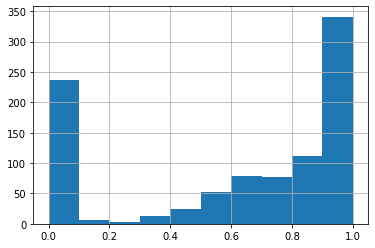

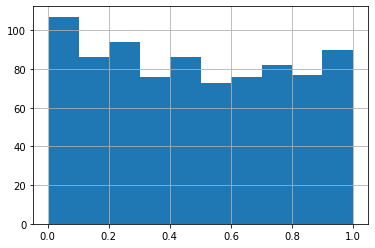

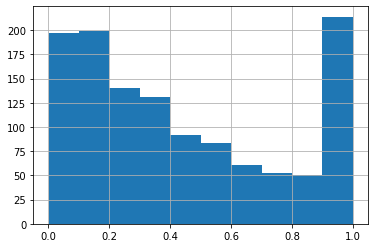

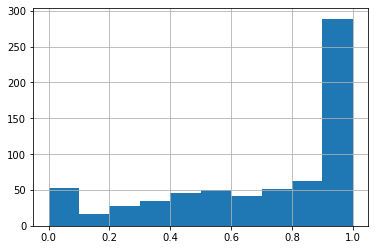

In [13]:
for n1, n2 in estimated_network.iloc[:, :2].values:
    condition = np.logical_and(estimated_progressions['from'] == n1, 
                          estimated_progressions['to'] == n2)
    estimated_progressions[condition]['percentage'].hist()
    plt.show()
    plt.close()

# 5. Prepare and save input for TraSig
<a id=5></a>

* 1. filter expression to leave only ligands and receptors in database  
* 2. save estimated clusters, progressions and true cell labels
* 3. save cells' s real time (if unknow, then put all as 0)

## 5.1 Save estimated cluster and progression time 

1. assigned path (edge)
2. assigned time / progression on the edge 
3. cell type labels (ground truth)

In [14]:
estimated_progressions['from'] = [i.decode('utf-8') for i in estimated_progressions['from']] 
estimated_progressions['to'] = [i.decode('utf-8') for i in estimated_progressions['to']] 
estimated_progressions['edge'] = estimated_progressions['from'] + '_' + estimated_progressions['to'] 

In [15]:
# assign unique label (integer) to each edge 

edges = np.unique(estimated_progressions['edge'])

edge2idx = {}
for i, v in enumerate(edges):
    edge2idx[v] = i

In [16]:
edge2idx

{'1_2': 0, '1_3': 1, '2_4': 2, '4_5': 3}

In [17]:
estimated_progressions['idx_edge'] = estimated_progressions['edge'].replace(edge2idx)

In [18]:
hid_var = {'cell_path': estimated_progressions['idx_edge'].values,
          'cell_time': estimated_progressions['percentage'].values,
          'cell_labels':assignment_true['milestone_id'].values} 

In [19]:
# save 
filename = f"{project}{_preprocess}_{model_name}_it2_hid_var.pickle"
with open(os.path.join(output_path, filename), 'wb') as handle:
    pickle.dump(hid_var, handle, protocol=pickle.HIGHEST_PROTOCOL)

###### check percent of cell types (true) in each edge

In [20]:
estimated_progressions['label'] = assignment_true['milestone_id'].values
estimated_progressions['count'] = 0  # place holder

In [21]:
for cur_edge in edges:
    print(f"Edge {cur_edge} with label {edge2idx[cur_edge]}")
    print(estimated_progressions[['label', 'edge', 'count']].groupby(['edge', 'label']).count().loc[cur_edge])
    print("\n")

Edge 1_2 with label 0
       count
label       
COP       28
MOL      678
NFOL       3
OPC      237


Edge 1_3 with label 1
       count
label       
COP      111
NFOL     503
OPC       58


Edge 2_4 with label 2
       count
label       
MOL      847


Edge 4_5 with label 3
       count
label       
MOL     1218
NFOL       2




## 5.2 Subsetting expression data (to keep only ligand-receptors )

1. the following take expression and ligand-receptor list (database) as input

In [22]:
# get interaction file (list of (ligand, receptor))
lr_list_path = "../ligand_receptor_lists"
list_type = 'ligand_receptor'
filename = f"{list_type }_FANTOM.pickle"

with open(os.path.join(lr_list_path, filename), 'rb') as handle:
    interaction_list = pickle.load(handle)
    
ligands_receptors = np.unique([i[0] for i in interaction_list] + [i[1] for i in interaction_list])

# get list of genes identified as ligand or receptor 
genes_upper = [g.upper() for g in genes]
kepted_genes = list(set(genes_upper).intersection(set(ligands_receptors)))

df = pd.DataFrame(expression)
df.columns = genes_upper
df.index = cell_ids

df_sub = df[kepted_genes]

# save filtered expression 
filename = f"{project}{_preprocess}_lr.txt"
data_file = os.path.join(output_path, filename)
df_sub.to_csv(data_file)


# save filtered interactions (list of (ligand, receptor) that are expressed)
filtered_interactions = []
for i, j in interaction_list:
    if i in kepted_genes and j in kepted_genes:
        filtered_interactions.append((i, j))
 

filename = f"{list_type}_{project}{_preprocess}.pickle"
with open(os.path.join(output_path, filename), 'wb') as handle:
    pickle.dump(filtered_interactions, handle, protocol=pickle.HIGHEST_PROTOCOL)


## 5.3 Save correspondence from sampling time to paths

1. Note here cell_path refers to the edge where the cell is assigned to 
2. We will only find interactions between cells from the same sampling time and those from consecutive sampling times:
    - i.e., between the ones from the same time, the ones from 1 sampling time before the ones from 1 sampling time after
3. Given we don't know the sampling time for the example data, we set all sampling time as 0. For your own data, if you are not certain about sampling time, just assign the time for all cells as 0.
4. If sampling time is known, rank the real time (e.g. day 0, day 17) first and assign the rank to the cell_ori_time variable below. 
    - e.g., for cells from two sampling time day 0 and day 17, assign those from day 0  as 0 and those from day 17 as 1. 

In [23]:
from scipy import stats

In [24]:
cell_ori_time = np.repeat(0, N)  # put all cells at time 0 if sampling time unknow 

In [25]:
unique_days = np.unique(cell_ori_time)
sorted_days = list(np.sort(unique_days)) 
cell_paths = np.unique(hid_var["cell_path"])

In [26]:
sampleT2path = dict.fromkeys(range(len(sorted_days)))  # use index of sorted sampling time as key
for k, v in sampleT2path.items():
    sampleT2path[k] = []

In [27]:
for i, cur_path in enumerate(cell_paths):
    print("current path (edge)", cur_path)
    
    # get data corresponding to a path
    condition = hid_var["cell_path"] == cur_path
    cur_days = np.array(cell_ori_time)[condition]
    
    # get the sampling time for the majority cells 
    mode, count = stats.mode(cur_days)
    print(f"Sampling time for the majority of cells: {mode[0]}, making {round(float(count[0])/len(cur_days), 2)}% percent")
    cur_sampleT = mode[0]
    
    # will use index instead of input time 
    sampleT2path[sorted_days.index(cur_sampleT)].append(cur_path)
    

current path (edge) 0
Sampling time for the majority of cells: 0, making 1.0% percent
current path (edge) 1
Sampling time for the majority of cells: 0, making 1.0% percent
current path (edge) 2
Sampling time for the majority of cells: 0, making 1.0% percent
current path (edge) 3
Sampling time for the majority of cells: 0, making 1.0% percent


In [28]:
# save the dictionary
filename = 'sampling_time_per_path_' + project + suffix + '.pickle'

with open(os.path.join(output_path, filename), 'wb') as handle:
    pickle.dump(sampleT2path, handle, protocol=pickle.HIGHEST_PROTOCOL)